<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/split-step-fourier-method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
plt.style.use('ggplot')

In [0]:
################### Physical Parameters  ########################
Ip = 4**2;                           #peak intensity
Ib = 1.0;                             #background illumination
Lambda = 0.5e-6;                      #wavelength
k0 = 2*np.pi/Lambda;                  #vacuum wavevector
n0 = 1;                               #background index of refraction
w0 = 0.5e-3;

Lz = 5;                               #computational length of sample
Lx = 30e-3;                           #computational width of sample

Chirp = -0.0*6*230000.0;              #input linear chirp parameter

# inputposition=-0*10^(-6);           #input position
h = 0.67e-3;
inputposition = +h/2;                 #input position

Radius = 1.2e-3;


In [0]:
################## Computational Parameters #############

nstepx = 1*1024;                #number of transverse grid points
nstepz = 50;     #200            #number of longitudinal propagation steps
deltax = Lx/nstepx;
deltaz = Lz/nstepz;    #the resolution in the z direction, IMPORTANT
deltaf = 1/Lx;                  #spatial frequency step

In [0]:
##########################  GENERAL GRID SET-UP  ##########################

z = np.arange(0, Lz, deltaz)                #z grid
x = -Lx/2 + deltax/2+(np.arange(0, nstepx, 1))*deltax;                       # x array

X, Y = np.meshgrid(x,x);

In [0]:
##########################  Dispersive Step Setup #########################

ntx = 0;             
kx = np.zeros(nstepx)                                          #this is to get rid of fftshifts and the sort
for nn in range(nstepx):
    ikx = nn - ntx;
    kx[nn] = 2*np.pi*deltaf*ikx;
    if nn + 1 - nstepx/2 == 0 :
      ntx = nstepx;

KX, KY = np.meshgrid(kx, kx);

ArgumentOfPropagator  =  ((k0*n0)**(-1)*(KX**2+KY**2))*(deltaz/4.);                  #### propagao per dz/2 (il 4 � perch� c'� anche un fattore 2 nel propagatore)
Propagator = np.cos(ArgumentOfPropagator)+1j*np.sin(ArgumentOfPropagator);

In [0]:
####################### INPUT FIELDS DEFINITION  #########################

# InputField = sqrt(Ip)*exp(i*Chirp*x-(x-inputposition).^2./(w0^2));    #input field shape
InputField = np.sqrt(Ip)*np.exp(-(X-0*inputposition)**2/(w0**2)-(Y-0*inputposition)**2/(w0**2));  #input field shape
InputField = 1+0*X;
InputField[np.sqrt(X**2+Y**2)>Radius] = 0;


# InputFields = sqrt(Ip)*(exp(-(x-inputposition).^20./(w0^20))+exp(-(x-inputposition+h).^20./(w0^20))); #input field shape
#plt.pcolor(X,Y,InputField**2)

# [ZZ XX] = meshgrid(z,x);
# MatrixAppoggio = 0.*ZZ+NaN;
# MatrixAppoggio2 = 0.*ZZ+NaN;

MatrixAppoggio = np.zeros(shape=(nstepx, nstepx, nstepz))
MatrixAppoggio[..., 0] = np.abs(InputField)**2

In [0]:
from matplotlib.colors import LinearSegmentedColormap

# we use a colormap similar to the one observed in lab
# when using lasers, black with no light, red at maximum intensity

cdict = {'red':   [[0.0,  0.0, 0.0],
                   [1.0,  1.0, 1.0]],
         'green': [[0.0,  0.0, 0.0],
                   [1.0,  0.0, 0.0]],
         'blue':  [[0.0,  0.0, 0.0],
                   [1.0,  0.0, 0.0]]}

cmap = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)

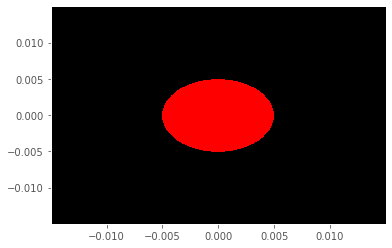

In [33]:

plt.pcolor(X,Y,abs(InputField)**2, cmap=cmap)

In [0]:
fft2, ifft2= np.fft.fft2, np.fft.ifft2

In [71]:
####################################################################)#
######                    PROPAGATION LOOP                  ########
####################################################################
tstart = time.time()
for hh in range(nstepz):
    
    ################### DISPERSIVE HALF STEP ############################
    
    InputFieldTransform = fft2(InputField)
    InputFieldTransform = InputFieldTransform*Propagator;
    InputField = ifft2(InputFieldTransform)
    
    ################### DISPERSIVE HALF STEP ############################
    InputFieldTransform = fft2(InputField)
    #InputFieldTransform = fftshift(InputFieldTransform);
    InputFieldTransform = InputFieldTransform*Propagator;
    InputField = ifft2(InputFieldTransform)
    #InputField = ifftshift(InputField);
    
  
    MatrixAppoggio[..., hh] = abs(InputField)**2;
    
print(f"Lasted {time.time()-tstart} seconds")
inputpower = np.sum(MatrixAppoggio[...,1])
outputpower = np.sum(MatrixAppoggio[...,-1])

energy_gap = (outputpower-inputpower)/(outputpower+inputpower)
if energy_gap != 0:
  print(energy_gap)

Lasted 11.238396406173706 seconds
3.2802580360071318e-15


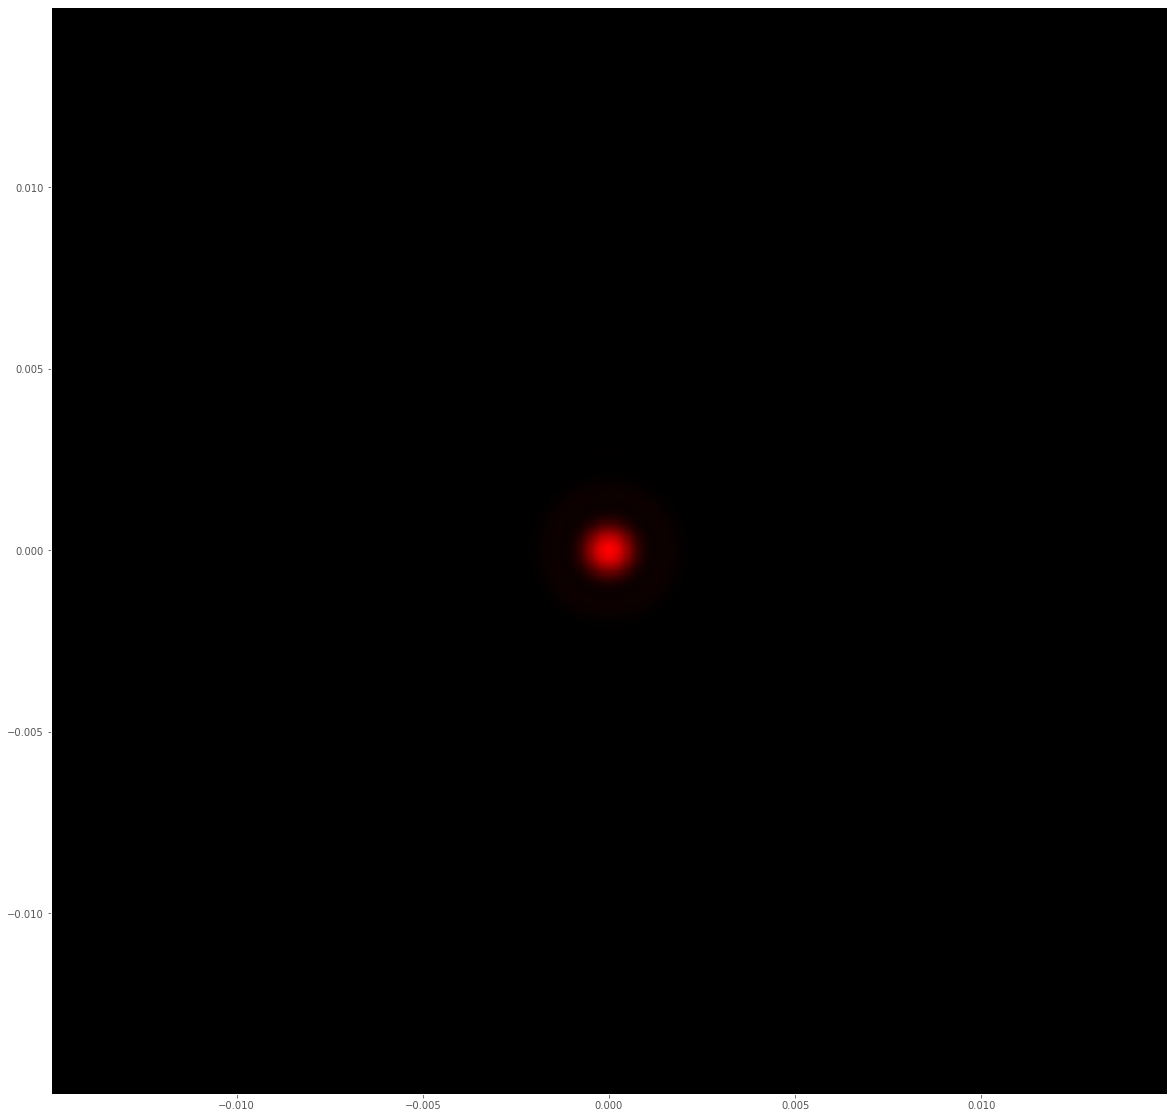

In [72]:
plt.close()
fig, ax = plt.subplots(figsize=(20, 20))
ax.pcolor(X, Y, MatrixAppoggio[...,-1], cmap=cmap)
plt.show()

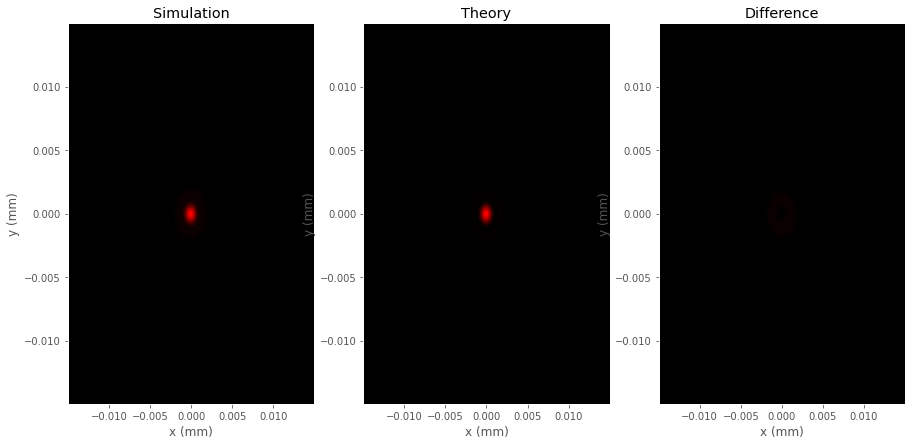

In [73]:
from scipy.special import jv as besselj

R = np.sqrt(X**2+Y**2);
theta = np.arctan(R/z[-1]);
rho = k0*Radius*np.sin(theta);
I_theory = (2*besselj(1,rho)/rho)**2;
I_max = np.max(MatrixAppoggio[..., -1])
I_theory = I_theory/np.max(I_theory)*I_max;

plt.close()
fig, axs = plt.subplots(1, 3, figsize=(15, 7))
axs[0].set(
    ylabel='y (mm)',
    xlabel='x (mm)',
    title='Simulation',
)
axs[0].pcolor(X, Y, MatrixAppoggio[..., -1], cmap=cmap, vmin=0, vmax=I_max);
axs[1].set(
    ylabel='y (mm)',
    xlabel='x (mm)',
    title='Theory',
)
axs[1].pcolor(X, Y, I_theory, cmap=cmap, vmin=0, vmax=I_max);
axs[2].set(
    ylabel='y (mm)',
    xlabel='x (mm)',
    title='Difference',
)
axs[2].pcolor(X, Y, MatrixAppoggio[..., -1] - I_theory, cmap=cmap, vmin=0, vmax=I_max);
